## The PDE example

The PDE equation is:

$$\frac{\partial \phi}{\partial t}=-u\frac{\partial \phi}{\partial x}$$

With the initial value:
$$\phi_0 = \phi(x,0)$$

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# tf.compat.v1.disable_eager_execution()

# 1. Build model

## [Model](https://weikaiwei.com/tf/tensorflow-2-mnist-2/)

In [3]:
class solve_PDE_Model():
    def __init__(self, loss_calculator):
        self.loss_calculator = loss_calculator
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        self.metrics = tf.keras.metrics.Mean(0.001)

        inputs = tf.keras.Input(shape=(2,), name="inputs")
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer1')(inputs)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer2')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer3')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer4')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer5')(x)
        outputs = tf.keras.layers.Dense(units=1, name='output')(x)
    
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
            

    def predict(self, x_data, t_data):
        print("Start prediction")
        input_data = tf.stack([tf.reshape(x_data, [-1]), tf.reshape(t_data, [-1])], axis=1)
        return self.model(input_data)

    def train(self, x_data, t_data, epochs):
        print("Start training")
        self.metrics.reset_states()

        for epoch in range(epochs):
            self.train_epoch(x_data, t_data)

            if(epoch%500 == 0):
                print("Epoch {0}, Loss {1}".format(epoch, self.metrics.result()))

    @tf.function
    def train_epoch(self, x_data, t_data):
        with tf.GradientTape() as tape:
            x_data_reshape = tf.reshape(x_data, [-1])
            t_data_reshape = tf.reshape(t_data, [-1])
            input_data = tf.stack([x_data_reshape, t_data_reshape], axis=1)

            # Run forward
            phi = self.model(input_data)
            # Compute the loss value
            loss = self.loss_calculator.loss(x_data_reshape, t_data_reshape, phi)


        # Update metrics
        self.metrics.update_state(loss)

        # Compute gradients
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        #Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))


## [Loss function](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses)

In [4]:
class PDE_Loss():
    def __init__(self, phi_init, u, regularization_factor=0.1):
        self.phi_init = phi_init
        self.u = u

    def loss(self, x_data, t_data, phi):
        phi_t = tf.gradients(phi, t_data)[0]
        phi_x = tf.gradients(phi, x_data)[0]

        phi_t = tf.reshape(phi_t, [phi_t.shape[0],1])
        phi_x = tf.reshape(phi_x, [phi_x.shape[0],1])
        
        governing_Eq = phi_t+self.u+phi_x
        
        init_size = self.phi_init.shape[0]

        number_of_time_step = governing_Eq.shape[0] / init_size

        loss = tf.reduce_mean(tf.square(phi[:init_size]-self.phi_init)) 

        for one_time_step in range(1, int(number_of_time_step)):
                    
            loss += tf.reduce_sum(tf.square(
                # governing_Eq in loss   
                governing_Eq[one_time_step*init_size+1:(one_time_step+1)*init_size-1]
            ))
    
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[one_time_step*init_size][0]-1.0) 
            ))
        
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[(one_time_step+1)*init_size-1][0]-1.0)
            ))
                

        return loss
    


In [8]:
lx = 2
nx = 20
dx = lx / (nx-1)

lt = 0.04
nt = 4
dt = lt / (nt-1)

u = 1      #assume wavespeed of u = 1

x_line = tf.linspace(0.0, lx, nx, name="x")
t_line = tf.linspace(0.0, lt, nt, name="t")
x_init = tf.identity(x_line, name="x_init")
x, t = tf.meshgrid(x_line, t_line)

x = tf.reshape(x, [-1])
t = tf.reshape(t, [-1])

# tf.reshape(x, [-1])
x
# input_data = tf.stack([x, t], axis=1)
# input_data

# # sine wave init
# np_phi_init = np.ones(nx)
# sine_wave = np.linspace(0,2*np.pi, int(1.5 / dx + 1) - int(.5 / dx) )
# np_phi_init[int(.5 / dx):int(1.5 / dx + 1)] += np.sin(sine_wave)
# phi_init = tf.convert_to_tensor(np_phi_init, dtype=tf.float32, name="phi_init")
# phi_init = tf.reshape(phi_init, [phi_init.shape[0],1])

# loss_calculator = PDE_Loss(phi_init,u)
# myModel = solve_PDE_Model(loss_calculator)
# myModel.train(x, t, 50000)


<tf.Tensor: shape=(80,), dtype=float32, numpy=
array([0.        , 0.10526316, 0.21052632, 0.31578946, 0.42105263,
       0.5263158 , 0.6315789 , 0.7368421 , 0.84210527, 0.94736844,
       1.0526316 , 1.1578947 , 1.2631578 , 1.3684211 , 1.4736842 ,
       1.5789474 , 1.6842105 , 1.7894737 , 1.8947369 , 2.        ,
       0.        , 0.10526316, 0.21052632, 0.31578946, 0.42105263,
       0.5263158 , 0.6315789 , 0.7368421 , 0.84210527, 0.94736844,
       1.0526316 , 1.1578947 , 1.2631578 , 1.3684211 , 1.4736842 ,
       1.5789474 , 1.6842105 , 1.7894737 , 1.8947369 , 2.        ,
       0.        , 0.10526316, 0.21052632, 0.31578946, 0.42105263,
       0.5263158 , 0.6315789 , 0.7368421 , 0.84210527, 0.94736844,
       1.0526316 , 1.1578947 , 1.2631578 , 1.3684211 , 1.4736842 ,
       1.5789474 , 1.6842105 , 1.7894737 , 1.8947369 , 2.        ,
       0.        , 0.10526316, 0.21052632, 0.31578946, 0.42105263,
       0.5263158 , 0.6315789 , 0.7368421 , 0.84210527, 0.94736844,
       1.052631

In [5]:
result = myModel.predict(x, t)
print(result)

Start prediction
tf.Tensor(
[[1.0020164 ]
 [0.9314272 ]
 [0.92734057]
 [1.016303  ]
 [1.2175012 ]
 [1.5173483 ]
 [1.8280762 ]
 [1.9602896 ]
 [1.686097  ]
 [0.9929447 ]
 [0.31404406]
 [0.05800688]
 [0.18904787]
 [0.48218066]
 [0.7651874 ]
 [0.96392894]
 [1.0688361 ]
 [1.0968748 ]
 [1.0701976 ]
 [1.0080335 ]
 [1.0013586 ]
 [0.92392945]
 [0.9098984 ]
 [0.98571986]
 [1.1724504 ]
 [1.462646  ]
 [1.7803781 ]
 [1.9485384 ]
 [1.7347331 ]
 [1.0788089 ]
 [0.36737102]
 [0.05157402]
 [0.14546269]
 [0.4297086 ]
 [0.7199632 ]
 [0.9308246 ]
 [1.0469211 ]
 [1.0834385 ]
 [1.0625687 ]
 [1.004133  ]
 [1.0013813 ]
 [0.9174553 ]
 [0.8938965 ]
 [0.95693856]
 [1.1291517 ]
 [1.4085453 ]
 [1.7303809 ]
 [1.9304683 ]
 [1.7755276 ]
 [1.1636491 ]
 [0.4278146 ]
 [0.05200386]
 [0.10485858]
 [0.37718433]
 [0.67336446]
 [0.8961598 ]
 [1.0237275 ]
 [1.0690877 ]
 [1.0543412 ]
 [0.99986   ]
 [1.002049  ]
 [0.91195685]
 [0.879282  ]
 [0.9299279 ]
 [1.0876547 ]
 [1.3552823 ]
 [1.6785467 ]
 [1.9065597 ]
 [1.8082954 ]
 [1.24

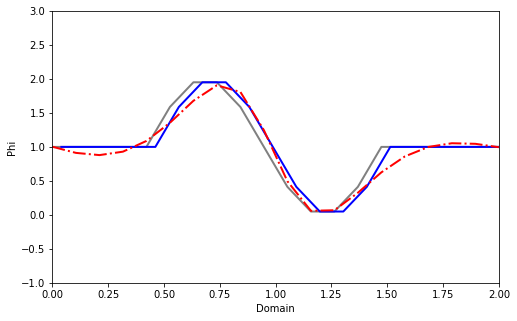

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

# create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
ax1.set_xlim((0, 2))            
ax1.set_ylim((-1, 3))
ax1.set_xlabel('Domain')
ax1.set_ylabel('Phi')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
n=3
txt_title = ax1.set_title('')
line1, = ax1.plot(tf.reshape(x_line, [-1]), phi_init, 'gray', lw=2)
line1, = ax1.plot(tf.reshape(x_line, [-1])+dt*n*u, phi_init, 'b', lw=2)
line2, = ax1.plot(tf.reshape(x_line, [-1]), result[n*nx:(n+1)*nx], 'r-.', lw=2)
# ax1.legend(['init','result'])